In [ ]:
import os

# --- CÉLULA DE CONFIGURAÇÃO ---
# Vamos criar a pasta 'data' e os ficheiros CSV necessários

# Criar a pasta 'data'
if not os.path.exists('data'):
    os.makedirs('data')

# Conteúdo do locais.csv
locais_csv = """ID_Local,Nome,Coord_X,Coord_Y
0,Sabor Express (Restaurante),5,5
1,Bairro A,1,2
2,Bairro B,3,8
3,Bairro C,7,2
4,Bairro D,9,9
5,Bairro E,2,1
"""

# Conteúdo do ruas.csv
ruas_csv = """De,Para,Peso
0,1,7
0,2,5
0,3,8
1,5,3
2,4,6
3,4,4
5,2,10
"""

# Escrever os ficheiros no ambiente do Colab
with open('data/locais.csv', 'w') as f:
    f.write(locais_csv)

with open('data/ruas.csv', 'w') as f:
    f.write(ruas_csv)

print("Ambiente preparado: Pasta 'data' e ficheiros CSV criados com sucesso!")
print("Pode verificar no explorador de ficheiros à esquerda.")

Ambiente preparado: Pasta 'data' e ficheiros CSV criados com sucesso!
Pode verificar no explorador de ficheiros à esquerda.


--- [PASSO 1: CARREGANDO O GRAFO] ---
Grafo criado com sucesso!
Nós (6): [(0, 'Sabor Express (Restaurante)'), (1, 'Bairro A'), (2, 'Bairro B'), (3, 'Bairro C'), (4, 'Bairro D'), (5, 'Bairro E')]
Arestas (7): [(0, np.int64(1), np.int64(7)), (0, np.int64(2), np.int64(5)), (0, np.int64(3), np.int64(8)), (1, np.int64(5), np.int64(3)), (2, np.int64(4), np.int64(6)), (2, np.int64(5), np.int64(10)), (3, np.int64(4), np.int64(4))]
----------------------------------------
--- [PASSO 2: EXECUTANDO K-MEANS] ---
Pedidos simulados (IDs): [1, 2, 3, 4, 5]
Pedidos agrupados por entregador:
  Entregador 0: [1, 3, 5]
  Entregador 1: [2, 4]
----------------------------------------
--- [PASSO 3: CALCULANDO ROTA A*] ---

Calculando Rota para Entregador 0 (Pedidos: [1, 3, 5])
  Rota Completa: [0, np.int64(1), np.int64(5), np.int64(1), np.int64(0), np.int64(3)]
  Custo Total: 28

Calculando Rota para Entregador 1 (Pedidos: [2, 4])
  Rota Completa: [0, np.int64(2), np.int64(4)]
  Custo Total: 11
-------------

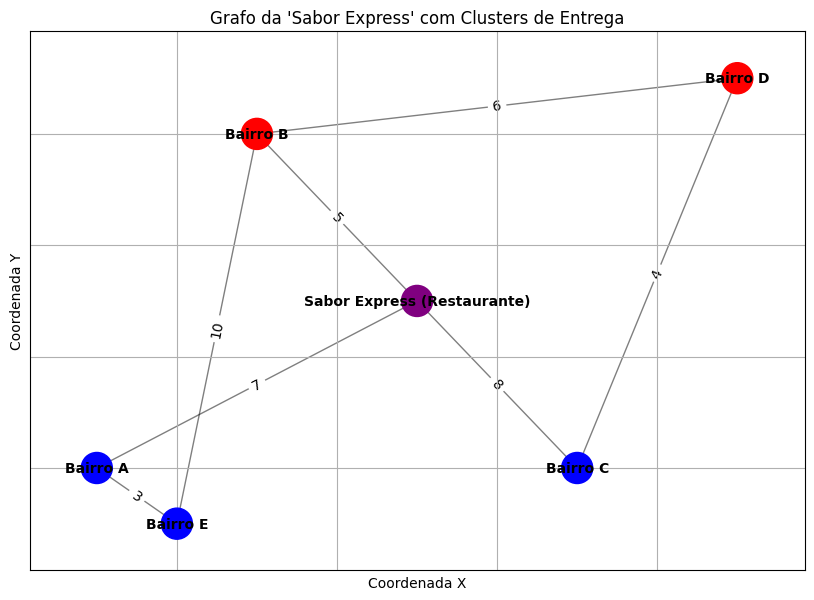

In [ ]:
import pandas as pd
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# --- PASSO 1: CARREGAR O GRAFO (LER OS CSVs) ---
print("--- [PASSO 1: CARREGANDO O GRAFO] ---")
try:
    df_locais = pd.read_csv('data/locais.csv')
    df_ruas = pd.read_csv('data/ruas.csv')
except FileNotFoundError:
    print("ERRO: Ficheiros 'data/locais.csv' ou 'data/ruas.csv' não encontrados.")
    print("Certifique-se de que executou a CÉLULA 1 (Configuração) primeiro.")
    exit()

# Criar o grafo
G = nx.Graph()

# Adicionar os nós (locais) ao grafo
posicoes = {} # Dicionário para guardar posições para o desenho
for index, row in df_locais.iterrows():
    G.add_node(row['ID_Local'], nome=row['Nome'], pos=(row['Coord_X'], row['Coord_Y']))
    posicoes[row['ID_Local']] = (row['Coord_X'], row['Coord_Y']) # Guarda a posição para o gráfico

# Adicionar as arestas (ruas) ao grafo
for index, row in df_ruas.iterrows():
    G.add_edge(row['De'], row['Para'], weight=row['Peso'])

print("Grafo criado com sucesso!")
print(f"Nós ({G.number_of_nodes()}): {list(G.nodes(data='nome'))}")
print(f"Arestas ({G.number_of_edges()}): {list(G.edges(data='weight'))}")
print("-" * 40)


# --- PASSO 2: APLICAR CLUSTERING (K-MEANS) ---
print("--- [PASSO 2: EXECUTANDO K-MEANS] ---")

# Simular uma lista de pedidos (IDs dos locais, exceto o restaurante 0)
id_pedidos = list(df_locais['ID_Local'].drop(0)) # Pega todos os IDs, menos o 0
numero_entregadores = 2 # Quantos clusters (grupos) queremos?

if not id_pedidos:
    print("Nenhum pedido para processar. Adicione locais (exceto 0) em locais.csv.")
    exit()

# Obter as coordenadas (pos) dos pedidos
coords_pedidos = [posicoes[id] for id in id_pedidos]
X = np.array(coords_pedidos)

# Aplicar K-Means
kmeans = KMeans(n_clusters=numero_entregadores, random_state=0, n_init=10).fit(X)

# Organizar os pedidos por grupo
grupos_de_entrega = {}
for i in range(numero_entregadores):
    grupos_de_entrega[i] = [] # Cria uma lista vazia para cada grupo

# Associa cada ID de pedido ao seu grupo
for i, id_pedido in enumerate(id_pedidos):
    grupo = kmeans.labels_[i]
    grupos_de_entrega[grupo].append(id_pedido)

print(f"Pedidos simulados (IDs): {id_pedidos}")
print("Pedidos agrupados por entregador:")
for grupo_id, pedidos_do_grupo in grupos_de_entrega.items():
    print(f"  Entregador {grupo_id}: {pedidos_do_grupo}")
print("-" * 40)


# --- PASSO 3: CALCULAR ROTA (A*) ---
print("--- [PASSO 3: CALCULANDO ROTA A*] ---")

ponto_partida = 0 # ID do Restaurante "Sabor Express"
nome_partida = G.nodes[ponto_partida]['nome']

# Vamos calcular as rotas para cada grupo
for grupo_id, pedidos_do_grupo in grupos_de_entrega.items():

    if not pedidos_do_grupo: # Pula se o grupo estiver vazio
        continue

    print(f"\nCalculando Rota para Entregador {grupo_id} (Pedidos: {pedidos_do_grupo})")

    ponto_atual = ponto_partida
    custo_total_grupo = 0
    rota_completa_grupo = [ponto_atual]

    pedidos_restantes = list(pedidos_do_grupo) # Copia a lista

    while pedidos_restantes:
        caminho_mais_curto = float('inf')
        proximo_destino = -1

        for destino in pedidos_restantes:
            try:
                custo = nx.astar_path_length(G, source=ponto_atual, target=destino, weight='weight')
                if custo < caminho_mais_curto:
                    caminho_mais_curto = custo
                    proximo_destino = destino
            except nx.NetworkXNoPath:
                print(f"Aviso: Não há caminho entre {ponto_atual} e {destino}")
                continue

        if proximo_destino == -1:
            print(f"Não foi possível encontrar rota para os pedidos restantes: {pedidos_restantes}")
            break

        rota_segmento = nx.astar_path(G, source=ponto_atual, target=proximo_destino, weight='weight')

        custo_total_grupo += caminho_mais_curto
        rota_completa_grupo.extend(rota_segmento[1:])

        ponto_atual = proximo_destino
        pedidos_restantes.remove(proximo_destino)

    print(f"  Rota Completa: {rota_completa_grupo}")
    print(f"  Custo Total: {custo_total_grupo}")

print("-" * 40)


# --- (OPCIONAL) PASSO 4: DESENHAR O GRAFO ---
print("--- [PASSO 4: DESENHANDO O GRAFO] ---")

# Cores para os clusters
cores_map = {0: 'blue', 1: 'red', 2: 'green', 3: 'yellow'}
cores_nos = []
for node in G.nodes():
    if node == 0: # Restaurante
        cores_nos.append('purple')
    elif node in id_pedidos:
        idx = id_pedidos.index(node)
        cor_grupo = kmeans.labels_[idx]
        cores_nos.append(cores_map[cor_grupo])
    else:
        cores_nos.append('grey')

# Desenhar
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G, posicoes, node_color=cores_nos, node_size=500)
nx.draw_networkx_edges(G, posicoes, width=1.0, alpha=0.5)
pesos_arestas = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, posicoes, edge_labels=pesos_arestas)
nomes_nos = nx.get_node_attributes(G, 'nome')
nx.draw_networkx_labels(G, posicoes, labels=nomes_nos, font_size=10, font_weight='bold')

plt.title("Grafo da 'Sabor Express' com Clusters de Entrega")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.axis('on')
plt.grid(True)
print("A exibir o gráfico...")
plt.show()